<a href="https://colab.research.google.com/github/aderylo/movie-genres-prediction/blob/master/Movies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from bs4 import BeautifulSoup

In [ ]:
from google.colab import drive 
drive.mount("/drive")

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
cd ../drive/MyDrive/NLP/

/drive/MyDrive/NLP


In [ ]:
df = pd.read_csv('mpst_full_data.csv', delimiter=',')
nRow, nCol = df.shape
df.head(5)

,imdb_id,title,plot_synopsis,tags,split,synopsis_source
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb


In [ ]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [ ]:
from tqdm import tqdm
preprocessed_synopsis = []
# tqdm is for printing the status bar
for sentance in df['plot_synopsis'].values:
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_synopsis.append(sentance.strip())
df['preprocessed_plots']=preprocessed_synopsis

In [ ]:
def remove_spaces(x):
    x=x.split(",")
    nospace=[]
    for item in x:
        item=item.lstrip()
        nospace.append(item)
    return (",").join(nospace)

df['tags']=df['tags'].apply(remove_spaces)
df['tags']

0                    cult,horror,gothic,murder,atmospheric
1                                                 violence
2                                                 romantic
3                      inspiring,romantic,stupid,feel-good
4        cruelty,murder,dramatic,cult,violence,atmosphe...
                               ...                        
14823                                        comedy,murder
14824                            good versus evil,violence
14825                                             anti war
14826                                               murder
14827                                       christian film
Name: tags, Length: 14828, dtype: object

In [ ]:
train=df.loc[df.split=='train']
train=train.reset_index()
test=df.loc[df.split=='test']
test=test.reset_index()

In [ ]:
cv=df.loc[df.split=="val"]
cv=cv.reset_index()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(tokenizer = lambda x: x.split(","), binary='true')
y_train = vectorizer.(train['tags']).toarray()
y_test = vectorizer.transform(test['tags']).toarray()

print(y_train)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
vectorizer.inverse_transform(y_train)[0]

array(['atmospheric', 'cult', 'gothic', 'horror', 'murder'], dtype='<U18')

In [ ]:
def max_len(x):
    a=x.split()
    return len(a)

max(df['plot_synopsis'].apply(max_len))

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
vect=Tokenizer()
vect.fit_on_texts(train['plot_synopsis'])
vocab_size = len(vect.word_index) + 1
print(vocab_size)

122195


In [ ]:
encoded_docs_train = vect.texts_to_sequences(train['preprocessed_plots'])
max_length = vocab_size
padded_docs_train = pad_sequences(encoded_docs_train, maxlen=1200, padding='post')
print(padded_docs_train)

[[  779  4660 62208 ...     0     0     0]
 [   51  4481   143 ...     0     0     0]
 [ 3063   429   188 ...    75   140  6946]
 ...
 [  140  2717   539 ...     0     0     0]
 [ 5118  2731  3015 ...     0     0     0]
 [ 1269  2392  2530 ...     0     0     0]]


In [ ]:
encoded_docs_test =  vect.texts_to_sequences(test['preprocessed_plots'])
padded_docs_test = pad_sequences(encoded_docs_test, maxlen=1200, padding='post')
encoded_docs_cv = vect.texts_to_sequences(cv['preprocessed_plots'])
padded_docs_cv = pad_sequences(encoded_docs_cv, maxlen=1200, padding='post')

In [ ]:
model = keras.Sequential()
# Configuring the parameters
model.add(layers.Embedding(vocab_size, output_dim=50, input_length=1200))
model.add(layers.LSTM(128, return_sequences=True))  
# Adding a dropout layer
model.add(layers.Dropout(0.5))
model.add(layers.LSTM(64))
model.add(layers.Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(layers.Dense(71, activation='sigmoid'))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1200, 50)          6109750   
                                                                 
 lstm (LSTM)                 (None, 1200, 128)         91648     
                                                                 
 dropout (Dropout)           (None, 1200, 128)         0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 71)                4615      
                                                                 
Total params: 6,255,421
Trainable params: 6,255,421
Non-

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model.compile(optimizer='adam', loss='binary_crossentropy', metrics = METRICS)

In [ ]:
history = model.fit(padded_docs_train,y_train,
                        epochs = 10,
                        verbose = 1,
                        validation_data=(padded_docs_test, y_test),
                        batch_size=16)

Epoch 1/10
594/594 [==============================] - 75s 109ms/step - loss: 0.1732 - tp: 1403.0000 - fp: 9257.0000 - tn: 636440.0000 - fn: 26619.0000 - accuracy: 0.9467 - precision: 0.1316 - recall: 0.0501 - auc: 0.7517 - val_loss: 0.1422 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 201564.0000 - val_fn: 9022.0000 - val_accuracy: 0.9572 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8295
Epoch 2/10
594/594 [==============================] - 63s 106ms/step - loss: 0.1451 - tp: 254.0000 - fp: 412.0000 - tn: 645285.0000 - fn: 27768.0000 - accuracy: 0.9582 - precision: 0.3814 - recall: 0.0091 - auc: 0.8009 - val_loss: 0.1412 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 201564.0000 - val_fn: 9022.0000 - val_accuracy: 0.9572 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8328
Epoch 3/10
594/594 [==============================] - 58s 97ms/step - loss: 0.1742 - tp: 228.0000 - fp: 3827.0000 - tn: 641870.0000 - fn: 27794.0000 - accuracy: 0.953

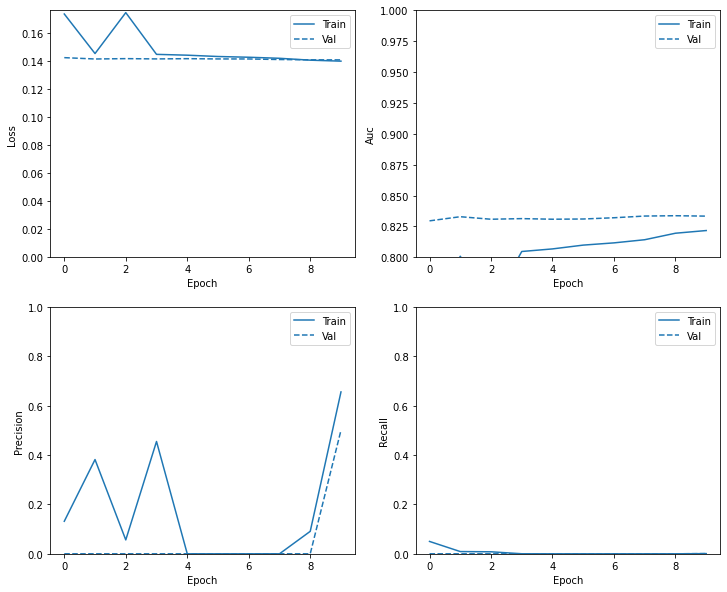

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

plot_metrics(history)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
predictions=model.predict([padded_docs_test])
thresholds=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

for val in thresholds:
    print("For threshold: ", val)
    pred=predictions.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0
  
    precision = precision_score(y_test, pred, average='micro')
    recall = recall_score(y_test, pred, average='micro')
    f1 = f1_score(y_test, pred, average='micro')
   
    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

For threshold:  0.1
Micro-average quality numbers
Precision: 0.2098, Recall: 0.5750, F1-measure: 0.3074
For threshold:  0.2
Micro-average quality numbers
Precision: 0.2941, Recall: 0.3116, F1-measure: 0.3026
For threshold:  0.3
Micro-average quality numbers
Precision: 0.3468, Recall: 0.2329, F1-measure: 0.2786
For threshold:  0.4
Micro-average quality numbers
Precision: 0.3908, Recall: 0.1319, F1-measure: 0.1972
For threshold:  0.5
Micro-average quality numbers
Precision: 0.5000, Recall: 0.0010, F1-measure: 0.0020
For threshold:  0.6


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Micro-average quality numbers
Precision: 0.0000, Recall: 0.0000, F1-measure: 0.0000
For threshold:  0.7
Micro-average quality numbers
Precision: 0.0000, Recall: 0.0000, F1-measure: 0.0000
For threshold:  0.8
Micro-average quality numbers
Precision: 0.0000, Recall: 0.0000, F1-measure: 0.0000
For threshold:  0.9
Micro-average quality numbers
Precision: 0.0000, Recall: 0.0000, F1-measure: 0.0000


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def predict_sample():
    t = train.sample(1)
    encoded_docs = vect.texts_to_sequences(t['preprocessed_plots'])
    padded_docs = pad_sequences(encoded_docs, maxlen=1200, padding='post')
    pred = model.predict(padded_docs).tolist()
    for i in range(len(pred[0])):
        if(pred[0][i] < 0.1):
            pred[0][i] = 0
        else:
            pred[0][i] = 1
    
    print("Original tags -->", t['tags'].values)
    print("Predicted tags -->", vectorizer.inverse_transform(pred))

predict_sample()

Original tags --> ['entertaining,comedy,murder,violence,good versus evil,humor,satire,action,revenge,alternate history,sadist,sci-fi']
Predicted tags --> [array(['comedy', 'cult', 'flashback', 'murder', 'psychedelic', 'revenge',
       'romantic', 'violence'], dtype='<U18')]
